In [15]:
# pip install prophet

In [17]:
# !pip install --upgrade numpy

In [3]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

In [5]:
# Load the dataset
try:
    filepath = 'data_files/day.csv'
    df = pd.read_csv(filepath)
except FileNotFoundError:
    print("Error: dataset not found!!!!")

In [9]:
if 'df' in locals():
    print(df.head())
    print(f"\nDataset shape: {df.shape}")

   instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1        0        6           0   
1        2  2011-01-02       1   0     1        0        0           0   
2        3  2011-01-03       1   0     1        0        1           1   
3        4  2011-01-04       1   0     1        0        2           1   
4        5  2011-01-05       1   0     1        0        3           1   

   weathersit      temp     atemp       hum  windspeed  casual  registered  \
0           2  0.344167  0.363625  0.805833   0.160446     331         654   
1           2  0.363478  0.353739  0.696087   0.248539     131         670   
2           1  0.196364  0.189405  0.437273   0.248309     120        1229   
3           1  0.200000  0.212122  0.590435   0.160296     108        1454   
4           1  0.226957  0.229270  0.436957   0.186900      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600  

Dataset shape: (731, 16)


##### Preparing the Data for Prophet


Data prepared for Prophet:
          ds     y
0 2011-01-01   985
1 2011-01-02   801
2 2011-01-03  1349
3 2011-01-04  1562
4 2011-01-05  1600


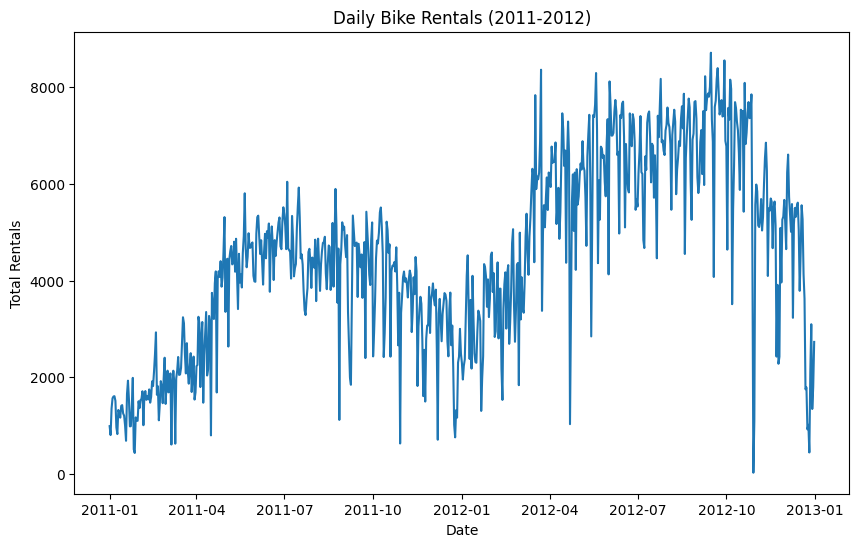

In [12]:
if 'df' in locals():
    # 1. Select and rename the columns
    # 'dteday' is the date column
    # 'cnt' is the total number of bike rentals
    df_prophet = df[['dteday', 'cnt']].copy()
    df_prophet.columns = ['ds', 'y']
    
    # 2. Convert 'ds' to datetime objects
    df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
    
    print("\nData prepared for Prophet:")
    print(df_prophet.head())
    
    # Plot the data to see what it looks like
    plt.figure(figsize=(10, 6))
    plt.plot(df_prophet['ds'], df_prophet['y'])
    plt.title('Daily Bike Rentals (2011-2012)')
    plt.xlabel('Date')
    plt.ylabel('Total Rentals')
    plt.show()

##### Building a Basic Model

In [15]:
if 'df_prophet' in locals():
    # 1. Initialize the model
    # Prophet will automatically detect yearly and weekly seasonality
    model_basic = Prophet()
    
    # 2. Fit the model
    model_basic.fit(df_prophet)
    
    # 3. Create a 'future' DataFrame to predict on
    # We'll ask it to predict 180 days into the future
    future_basic = model_basic.make_future_dataframe(periods=180)
    
    # 4. Make the forecast
    forecast_basic = model_basic.predict(future_basic)
    
    # Display the last few rows of the forecast
    print("\n--- Basic Forecast Output ---")
    print(forecast_basic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

18:28:13 - cmdstanpy - INFO - Chain [1] start processing
18:28:14 - cmdstanpy - INFO - Chain [1] done processing



--- Basic Forecast Output ---
            ds         yhat   yhat_lower   yhat_upper
906 2013-06-25  8438.973253  7184.642571  9667.093562
907 2013-06-26  8460.543580  7182.371248  9734.812728
908 2013-06-27  8564.696290  7246.000735  9795.894907
909 2013-06-28  8574.851180  7310.361048  9817.158621
910 2013-06-29  8467.934547  7141.301003  9602.090935


##### Plotting the Forecast and Components


Plotting basic forecast...


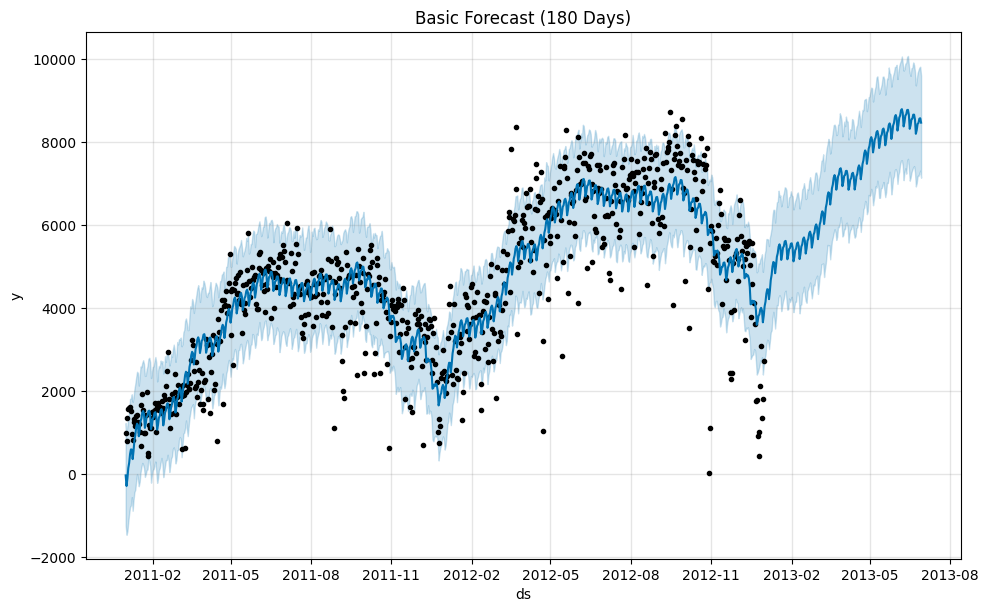


Plotting forecast components...


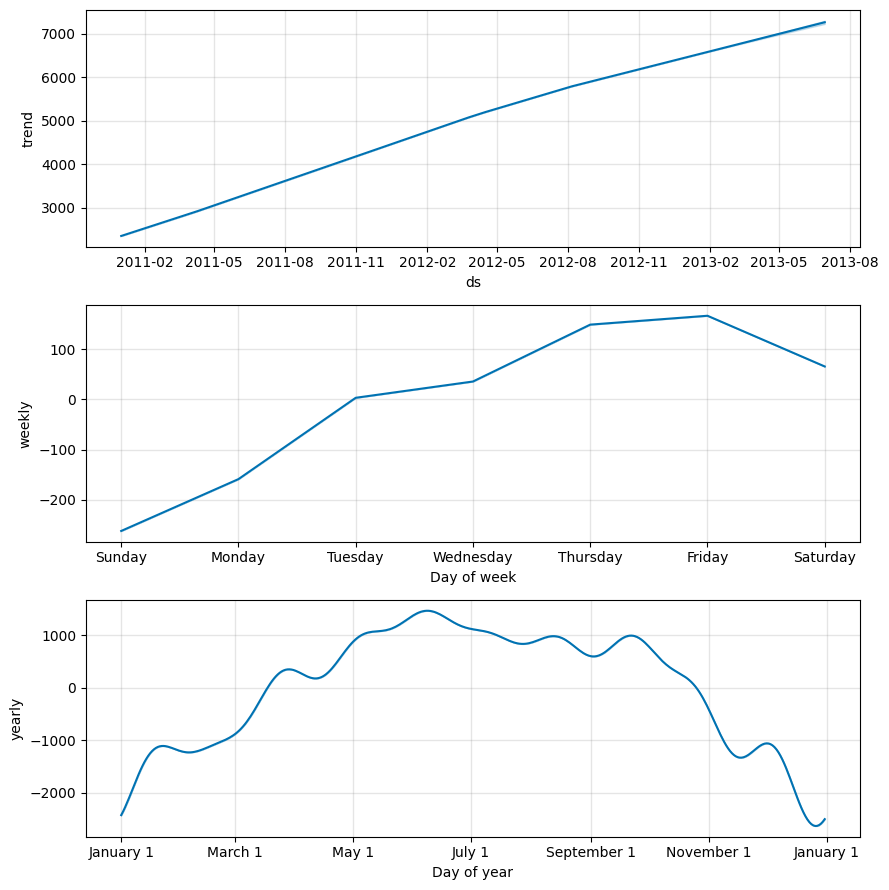

In [18]:
if 'model_basic' in locals():
    # 1. Plot the forecast
    # This shows the original data (black dots) and the model's fit/forecast (blue line)
    print("\nPlotting basic forecast...")
    fig1 = model_basic.plot(forecast_basic)
    plt.title('Basic Forecast (180 Days)')
    plt.show()
    
    # 2. Plot the components
    # It shows the individual patterns the model learned.
    print("\nPlotting forecast components...")
    fig2 = model_basic.plot_components(forecast_basic)
    plt.show()

##### Trend: The overall upward growth in bike rentals.

##### Weekly: A clear pattern showing low rentals on weekends and high rentals on weekdays (likely a commuter-heavy city).

##### Yearly: A smooth curve peaking in the summer (September) and bottoming out in the winter (January/February).

##### Improve the Model with Holidays


--- Custom Holidays DataFrame ---
            holiday         ds  lower_window  upper_window
16   public_holiday 2011-01-17             0             1
51   public_holiday 2011-02-21             0             1
104  public_holiday 2011-04-15             0             1
149  public_holiday 2011-05-30             0             1
184  public_holiday 2011-07-04             0             1

Training model with holidays...


18:30:27 - cmdstanpy - INFO - Chain [1] start processing
18:30:27 - cmdstanpy - INFO - Chain [1] done processing


Plotting advanced model components (with holidays)...


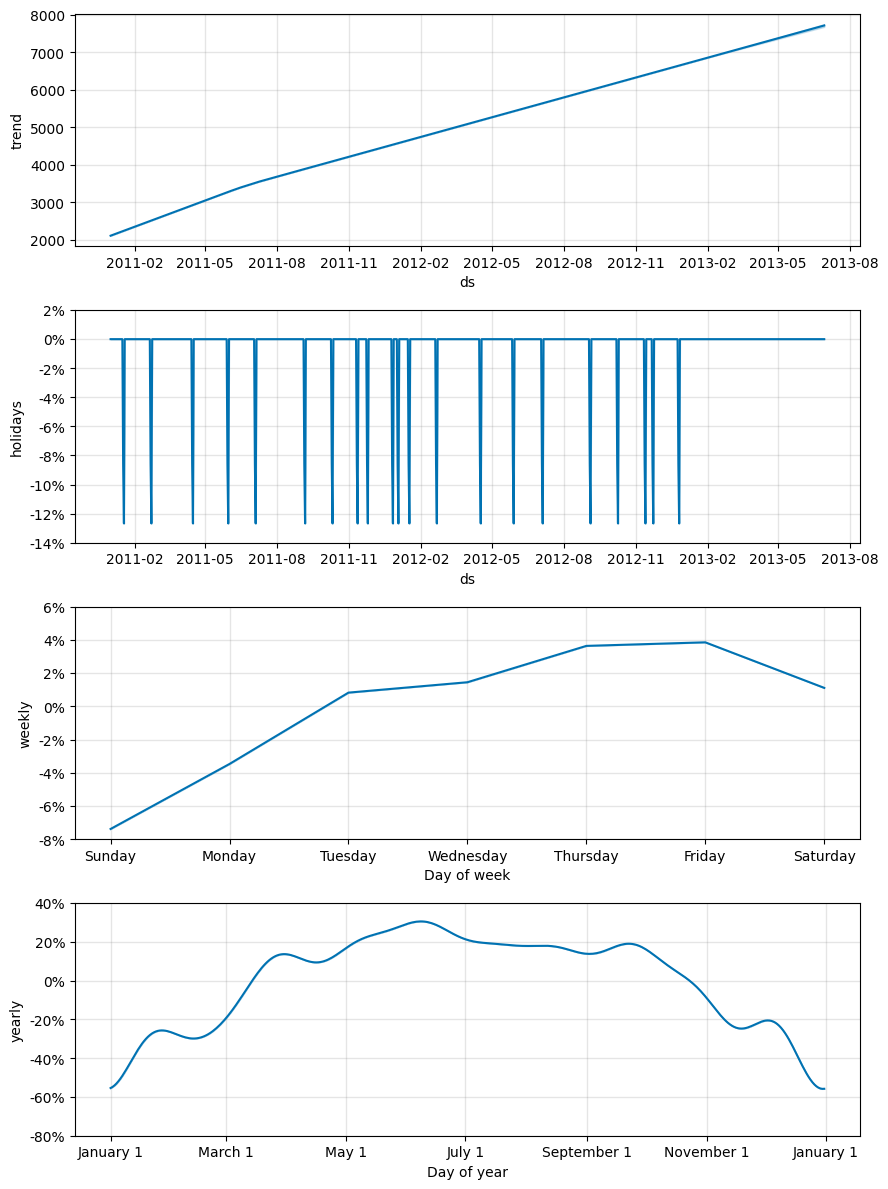

In [21]:
if 'df' in locals():
    # 1. Find all the dates that are holidays
    holiday_dates = df[df['holiday'] == 1]['dteday']
    
    # 2. Create the special 'holidays' DataFrame Prophet needs
    holidays_df = pd.DataFrame({
        'holiday': 'public_holiday',
        'ds': pd.to_datetime(holiday_dates),
        'lower_window': 0,
        'upper_window': 1, # Tell model the day *after* a holiday might also be affected
    })
    
    print("\n--- Custom Holidays DataFrame ---")
    print(holidays_df.head())

    # 3. Train a new, better model
    print("\nTraining model with holidays...")
    model_with_holidays = Prophet(
        holidays=holidays_df,
        seasonality_mode='multiplicative' # Try multiplicative seasonality
    )
    
    # We'll use our original df_prophet (with 'ds' and 'y')
    model_with_holidays.fit(df_prophet)

    # 4. Make a new forecast
    future_advanced = model_with_holidays.make_future_dataframe(periods=180)
    forecast_advanced = model_with_holidays.predict(future_advanced)
    
    # 5. Plot the new components
    # You will now see a FOURTH component: 'public_holiday'
    # This shows the model learned (e.g.) rentals drop by ~1000 on holidays.
    print("Plotting advanced model components (with holidays)...")
    fig3 = model_with_holidays.plot_components(forecast_advanced)
    plt.show()

##### By adding holidays, the model becomes much more robust because it no longer mistakes a holiday for a random anomaly; it learns it as a predictable event. This is a huge advantage of Prophet.